In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import tensorflow as tf
import tensorflow_hub as hub
import os
from tqdm.notebook import tqdm
import librosa
from scipy import signal

#PCA and clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# to use progress apply

from IPython.display import Audio
# animation
import matplotlib.animation as animation
import matplotlib

## Basic EDA of the dataset

the annotation file has some metadata fields that could be interesting to see how they're distributed and if there are some patterns in it

*
IMPORTANT: The TSV file only contains entries for positive time segments in a given wav_filename - remaining time can be considered negative.
IMPORTANT: There is a single zero-duration (0.0s) entry to indicate that a wav_filename contains only negative examples.

In [2]:
# basic statistics on annotations

df = pd.read_csv('TrainDataLatest_PodCastAllRounds_123567910/annotations.tsv',sep='\t')
df.head()
print('Train dataset has {} samples'.format(len(df)))

Train dataset has 5537 samples


In [3]:
df.head()

,dataset,wav_filename,start_time_s,duration_s,location,date,pst_or_master_tape_identifier
0,podcast_round1,60012.wav,34.126,2.918,"Dabob Bay, Seattle, Washington",1960-10-28,60012
1,podcast_round1,60012.wav,36.816,2.588,"Dabob Bay, Seattle, Washington",1960-10-28,60012
2,podcast_round1,60012.wav,42.550,2.055,"Dabob Bay, Seattle, Washington",1960-10-28,60012
3,podcast_round1,60012.wav,44.606,2.410,"Dabob Bay, Seattle, Washington",1960-10-28,60012
4,podcast_round1,60012.wav,46.636,3.425,"Dabob Bay, Seattle, Washington",1960-10-28,60012


In [4]:
# fix typo on the annotation tsv file

df['date'] = df.apply(lambda x: x['date'].split('-')[0][0:4],axis =1)
df['date'] = pd.to_datetime(df['date'])

# new columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

Most of the audios on the train partition are from podcast_round1

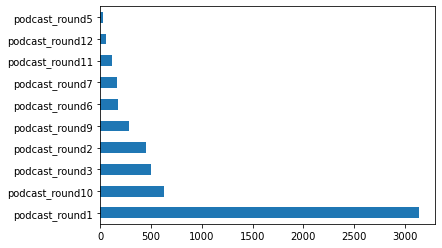

In [5]:
df['dataset'].value_counts().plot(kind='barh');

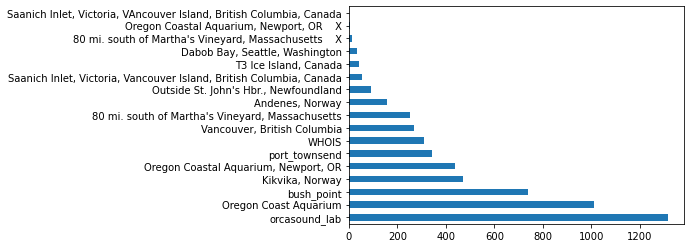

In [6]:
df['location'].value_counts().plot(kind='barh');

In [7]:
print('90% of audios have a duration less than {} seconds'.format(df['duration_s'].quantile(0.90)))
print('95% of audios have a duration less than {} seconds'.format(df['duration_s'].quantile(0.95)))


90% of audios have a duration less than 3.470333333333336 seconds
95% of audios have a duration less than 4.653799999999999 seconds


Duration of the clips in the dataset are important cause the duration of the sound event is an important descriptor to categorize sound events, this is also important because we're going to extract embeddings of audios and we must decide wether if we keep a long fixed size analysis window and noise-pad the shorter examples, or we take simple statistics on variable length audio clips.

<AxesSubplot:>

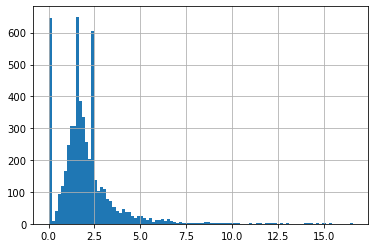

In [8]:
df['duration_s'].hist(bins=100)

# Embedding extraction

In [9]:
# load models
local_load = True
# load models from tensorflow hub using local route or online loading

if local_load:
    vggish_path = 'D:/orcaml/vggish_1/'
    yamnet_path = 'D:/orcaml/yamnet_1/'
    humpback_path = 'D:/orcaml/humpback_whale_1/'

    vggish_model = hub.load(vggish_path)
    yamnet_model = hub.load(yamnet_path)
    humpback_model = hub.load(humpback_path)
    
else: 
    
    vggish_model = hub.load('https://tfhub.dev/google/vggish/1')
    yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
    humpback_model = hub.load('https://tfhub.dev/google/humpback_whale/1')


In [10]:

def extract_embedding_from_signal(waveform,model):
    "Assumes the waveform has the correct sample rate"
    
    if model == 'vggish':
        embedding = vggish_model(waveform)
    if model == 'yamnet':
        scores, embedding, log_mel_spectrogram = yamnet_model(waveform)
    if model == 'humpback':
        
        waveform = tf.Variable(waveform.reshape([-1,1]),dtype=tf.float32)
        waveform = tf.expand_dims(waveform, 0)  # makes a batch of size 1
        pcen_spectrogram = humpback_model.front_end(waveform)
        
        # zero pad if lenght not a multiple of 128
        w_size = 128 # 3.84 seconds context window
        
        if pcen_spectrogram.shape[1] % w_size != 0:
            even_n = w_size - pcen_spectrogram.shape[1] % w_size
            pcen_spectrogram = tf.concat([pcen_spectrogram,tf.zeros([1,even_n,64])], axis=1)

        n_frames = int(pcen_spectrogram.shape[1]/w_size)

        batch_pcen_spectrogram = tf.reshape(pcen_spectrogram,shape=(n_frames,w_size,64)) 
        embedding = humpback_model.features(batch_pcen_spectrogram)
    
    return embedding


As a first test we're going to see how the embeedings in an audio file that contains positive examples of orca call could cluster the region 

1562337136_0005.wav
audio duration : 61.2499375
embedding shape: (127, 1024)
0.48228297244094487


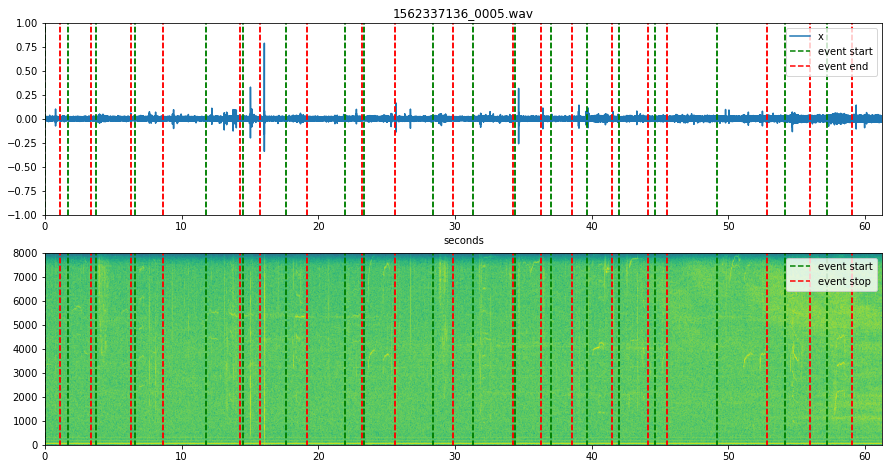

Explained variance:  0.40388019382953644


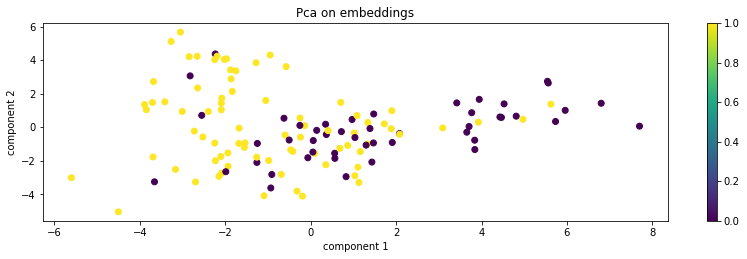

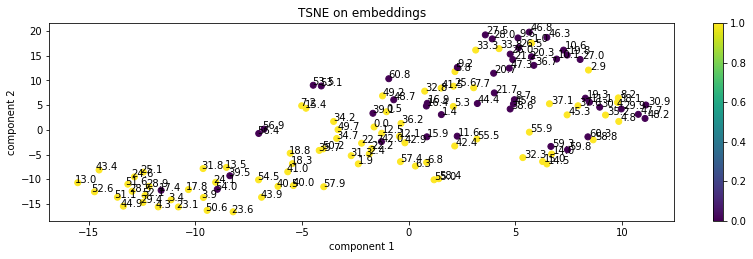

In [11]:
# read audios
cwd = os.getcwd()
audio_path = cwd + '/TrainDataLatest_PodCastAllRounds_123567910/wav/'

# select orcasound_lab 
df_lab = df[df['location'] == 'orcasound_lab']

for audio in tqdm(df_lab['wav_filename'].unique()):
    sub_df = df_lab[df_lab['wav_filename'] == audio].reset_index()
    # load audio file once
    x, fs = librosa.load(audio_path + audio, sr=16000)
    # time vector
    t = np.arange(len(x))/fs
    print(sub_df['wav_filename'].iloc[0])
    # compute embedding
    embedding = extract_embedding_from_signal(x,'yamnet')
    print('audio duration :',t[-1])
    print('embedding shape:',embedding.shape)
    print(t[-1]/embedding.shape[0])
    
    # embedding time vector
    t_embd = np.arange(0,t[-1],t[-1]/embedding.shape[0])

    act_vec = np.zeros([1,embedding.shape[0]])
    
    # plot waveform 
    plt.figure(figsize=(15,12))
    
    plt.subplot(3,1,1)
    plt.plot(t,x)
    plt.xlim([0,t[-1]])
    plt.ylim([-1,1])
    plt.title(sub_df['wav_filename'].iloc[0])
    plt.xlabel('seconds')
    
    # label audio regions
    for i, event in sub_df.iterrows():
        plt.axvline(event['start_time_s'],ymin=-1,ymax=1,color='green',ls='--')
        plt.axvline(event['start_time_s'] + event['duration_s'],ymin=-1,ymax=1,color='red',ls='--')
        idx = np.where( (t_embd >= event['start_time_s']) & (t_embd < (event['start_time_s'] + event['duration_s'] )) )
        act_vec[0,idx] = 1
    plt.legend(['x','event start','event end'])
    
    
    # plot spectrogram 
    plt.subplot(3,1,2)
    # default Nfft = 256
    # dfault overlap 50% = 128
    spec= plt.specgram(x,Fs=fs,NFFT=1024)
    plt.xlim([0,t[-1]])
    
    # label spectrogram regions
    for i, event in sub_df.iterrows():
        
        plt.axvline(event['start_time_s'],ymin=-1,ymax=1,color='green',ls='--')
        plt.axvline(event['start_time_s'] + event['duration_s'],ymin=-1,ymax=1,color='red',ls='--')
    
    plt.legend(['event start','event stop'])
    plt.show()
    
    # tf tensor to np.ndarray
    data = embedding.numpy()
    # PCA
    pca = PCA(n_components=2).fit(data)
    projected = pca.transform(data)
    print("Explained variance: " , sum(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(14,8))
    plt.subplot(2,1,1)
    # plot pca
    plt.title('Pca on embeddings')
    plt.scatter(projected[:, 0], projected[:, 1],c=act_vec)
    plt.colorbar()
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()
    
    # T-SNE
    
    perplexity = 17
    iteration = 750
    projected_tsne = TSNE(n_components=2,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(data)
    # plot ts2e
    plt.figure(figsize=(14,8))
    plt.subplot(2,1,2)

    plt.title('TSNE on embeddings')
    plt.scatter(projected_tsne[:, 0], projected_tsne[:, 1],c=act_vec)
    
    for i,time in enumerate(t_embd):
        plt.text(projected_tsne[i, 0]+projected_tsne[i, 0]*0.01,projected_tsne[i, 1] + projected_tsne[i, 1]*0.01,"{:.1f}".format(time))
    plt.colorbar()
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()
    # just one audio
    break

    

## Embedding animations

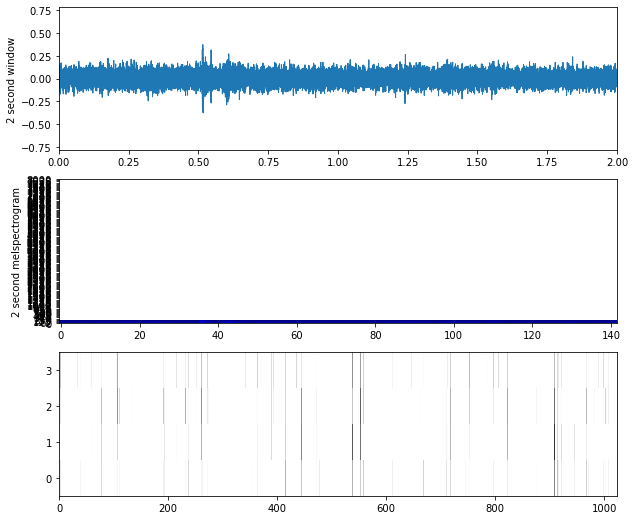

In [53]:



# read audios
cwd = os.getcwd()
audio_path = cwd + '/TrainDataLatest_PodCastAllRounds_123567910/wav/'

# select orcasound_lab 
df_lab = df[df['location'] == 'orcasound_lab']
rnd_example = df_lab.sample(1)
audio_file = rnd_example['wav_filename'].values[0]
x, fs = librosa.load(os.path.join(audio_path,audio_file), sr=16000)

def create_animation(x,fs,name='animation',frame_duration=2,time_ratio=2,model='vggish'):
    """ Create animation to the see the output of one embedding model """
    
    hop_size = int(fs/2) # half second
    hop_duration = hop_size/fs
    w_size = fs*frame_duration
    fps = int(1 / hop_duration) * time_ratio 
    steps = np.arange(0,x.size-w_size,hop_size)

    # Writer
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, metadata=dict(artist='Orcasound'), bitrate=1800)

    # create figure
    fig = plt.figure(figsize=(10,9))
    # subplots
    ax1 = fig.add_subplot(3,1,1)
    ax2 = fig.add_subplot(3,1,2)
    ax3 = fig.add_subplot(3,1,3)

    max_amp = np.max(np.abs(x))
    ax1.set_ylim([-max_amp,max_amp])
    ax1.set_xlim([0,frame_duration])
    ax1.set_ylabel('{} second window'.format(frame_duration))
    ax2.set_ylabel('{} second STFT'.format(frame_duration))
    
    ax2.set_yticks()

    line, = ax1.plot([], [], lw=1)

    def init():
        line.set_data([], [])
        return line,

    # animate function
    def animate(i):

        frame = x[steps[i]:steps[i]+w_size]
        t = np.arange(0,len(frame))/fs
        # plot waveform
        line.set_data(t,frame)
        line,

        # Run the model.
        embedding = extract_embedding_from_signal(frame,model)
        # calc spectrogram
        f, t, Sxx = signal.spectrogram(frame, fs)
        # plot spectrogram
        ax2.imshow(Sxx, origin='lower',aspect='auto',cmap='jet')   
        # Plot the embedding
        ax3.imshow(embedding.numpy(),origin='lower', aspect='auto', interpolation='nearest', cmap='gray_r')
        

    m = len(steps)
    ani = matplotlib.animation.FuncAnimation(fig, animate,init_func=init, frames=m,interval=int(hop_duration*1000))
    ani.save(name + '_yamnet.mp4', writer=writer)
    
create_animation(x,fs,name='animation_test_2',frame_duration=2,time_ratio=4,model='yamnet')

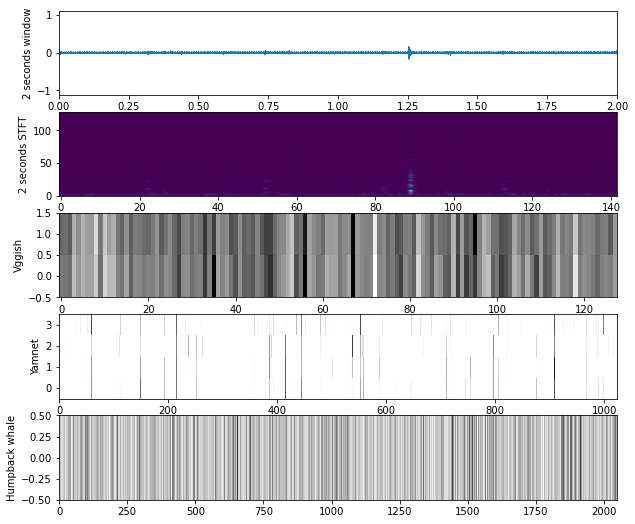

In [20]:


def create_animation_all_models(x,fs,name='animation',frame_duration=2,time_ratio=2):
    
    hop_size = int(fs/2) # half second
    hop_duration = hop_size/fs
    w_size = fs*frame_duration
    fps = int(1 / hop_duration) * time_ratio 
    steps = np.arange(0,x.size-w_size,hop_size)

    # Writer
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, metadata=dict(artist='Orcasound'), bitrate=1800)

    # create figure
    fig = plt.figure(figsize=(10,9))
    # subplots
    ax1 = fig.add_subplot(5,1,1)
    ax2 = fig.add_subplot(5,1,2)
    ax3 = fig.add_subplot(5,1,3)
    ax4 = fig.add_subplot(5,1,4)
    ax5 = fig.add_subplot(5,1,5)

    max_amp = np.max(np.abs(x))
    ax1.set_ylim([-max_amp,max_amp])
    ax1.set_xlim([0,frame_duration])
    ax1.set_ylabel('{} seconds window'.format(frame_duration))
    ax2.set_ylabel('{} seconds STFT'.format(frame_duration))
    ax3.set_ylabel('Vggish')
    ax4.set_ylabel('Yamnet')
    ax5.set_ylabel('Humpback whale')

    line, = ax1.plot([], [], lw=1)

    def init():
        line.set_data([], [])
        return line,

    # animate function
    def animate(i):

        frame = x[steps[i]:steps[i]+w_size]
        t = np.arange(0,len(frame))/fs
        line.set_data(t,frame)
        line,

        # Run the models.
        vggish_embedding = extract_embedding_from_signal(frame,'vggish')
        yamnet_embedding = extract_embedding_from_signal(frame,'yamnet')
        humpback_embedding = extract_embedding_from_signal(frame,'humpback')
        # calc spectrogram
        f, t, Sxx = signal.spectrogram(frame, fs)
        
        # plot spectrogram
        ax2.imshow(Sxx, origin='lower',aspect='auto',cmap='viridis')   
        
        # Plot the embedding
        ax3.imshow(vggish_embedding.numpy(),origin='lower', aspect='auto', interpolation='nearest', cmap='gray_r')
        # Plot the embedding
        ax4.imshow(yamnet_embedding.numpy(),origin='lower', aspect='auto', interpolation='nearest', cmap='gray_r')
        # Plot the embedding
        ax5.imshow(humpback_embedding.numpy(),origin='lower', aspect='auto', interpolation='nearest', cmap='gray_r')
        

    m = len(steps)
    ani = matplotlib.animation.FuncAnimation(fig, animate,init_func=init, frames=m,interval=int(hop_duration*1000/time_ratio))
    ani.save(name + '_all_models.mp4', writer=writer)
    
create_animation_all_models(x,fs,name='animation_',frame_duration=2,time_ratio=4)

# Extract  embeddings on the train Dataset(only positive examples) 

Extract embeddings with all the models on the train dataset of the orcaml repo and generate the files needed to publish the experiment in the tensorflow projector. 

In [4]:
embeddings = []
# read audios
cwd = os.getcwd()
audio_path = cwd + '/TrainDataLatest_PodCastAllRounds_123567910/wav/'
shapes = []
img_path = cwd + '/spec_img_vggish/'
metadata_file ='metadata_vggish.tsv'
embeddings_file = 'embeddings_vggish.tsv'

In [9]:

if not(os.path.exists(img_path)):
    os.mkdir(img_path)
    
# create metadata file
f_metadata = open(metadata_file,'w')
for label in df.columns:
    f_metadata.write('{}\t'.format(label))
f_metadata.write('\n')
n_sample = 0

with open(embeddings_file,'a') as f: 
    
    for audio in tqdm(df['wav_filename'].unique()):
        sub_df = df[df['wav_filename'] == audio]
        # load audio file once
        x, fs = librosa.load(audio_path + audio, sr=16000)
        for i,audio_event in sub_df.iterrows():
            
            start_sample = int(np.floor(audio_event['start_time_s']*fs))
            end_sample = start_sample + int(np.ceil(audio_event['duration_s']*fs)) 
            waveform = x[start_sample:end_sample]
            
            if len(waveform) > 10:
                try:
                    # generate spectrogram for sprite image
                    
                    plt.specgram(waveform,Fs=16000)
                    image_name = '{}{}_{}_{}.png'.format(img_path,audio_event['wav_filename'].split('.')[0],start_sample,n_sample)
                    plt.axis('off')
                    plt.savefig(image_name, bbox_inches='tight')
                    plt.close()
                    n_sample+=1
                    
                    # get embedding
                    embedding = get_embedding(waveform,'vggish')
                    # get mean embedding
                    mean_embedding = tf.math.reduce_mean(embedding,0).numpy()
                    
                   
                    # write embedding and metadata
                    if not(np.isnan(mean_embedding)).any():
                        for col in audio_event:
                            f_metadata.write('{}\t'.format(col))
                        f_metadata.write('\n')
                        for val in mean_embedding:
                            f.write('{0:.4f}\t'.format(val))
                        # new line
                        f.write('\n')
                except:
                    print('bad format')
                embeddings.append(embedding)
   
f_metadata.close()   

<ipython-input-9-aba3326293bd>:27: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=160).
  plt.specgram(waveform,Fs=10000)


## Generate Spritesheet from all of the saved sprectrograms

In [10]:
from PIL import Image

imglist = [filename for filename in os.listdir(img_path)]
# sort images according to the given name
imglist.sort(key= lambda f: int(f.split('_')[-1][:-4])) 

# make sprite image
images = [Image.open(img_path + filename).resize((100,100)) for filename in imglist]

image_width, image_height = images[0].size
one_square_size = int(np.ceil(np.sqrt(len(images))))
master_width = (image_width * one_square_size) 
master_height = image_height * one_square_size
spriteimage = Image.new(
    mode='RGBA',
    size=(master_width, master_height),
    color=(0,0,0,0))  # fully transparent
for count, image in enumerate(images):
    div, mod = divmod(count,one_square_size)
    h_loc = image_width*div
    w_loc = image_width*mod    
    spriteimage.paste(image,(w_loc,h_loc))
spriteimage.convert("RGB").save('sprite_vggish.jpg', transparency=0)